<a href="https://colab.research.google.com/github/NancyBiyahut/intrusion-detection-autoencoder/blob/main/LSTMautoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from mpl_toolkits import mplot3d
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from scipy.spatial.distance import euclidean
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score

In [58]:
df= pd.read_csv('kdd_train1.csv')
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [59]:
df= pd.read_csv('kdd_train1.csv')
data=df.copy()
categorical_features=[feature for feature in  df.columns if data[feature].dtypes=='O']
categorical_features

['protocol_type', 'service', 'flag', 'labels']

In [60]:
df_http = df[(df['service']=='http')]

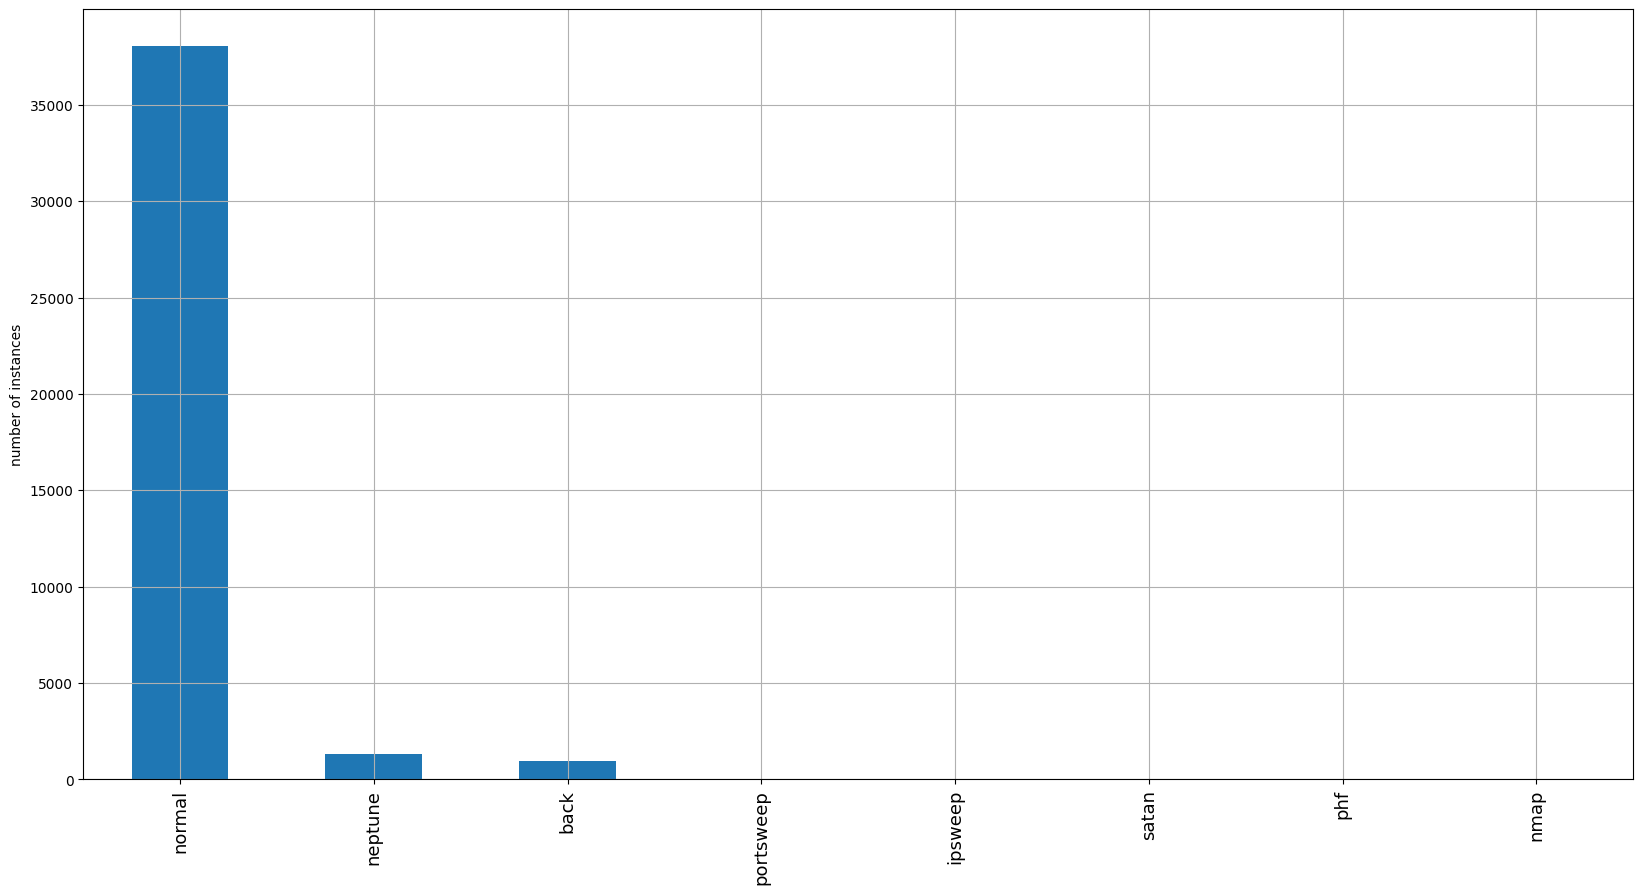

In [61]:
pd.value_counts(df_http['labels']).plot(kind='bar', figsize=(20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize=13)
plt.grid()
plt.show()

In [62]:
print('different types of services: {}'.format(df['service'].unique()))

different types of services: ['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001' 'aol' 'http_2784' 'tftp_u' 'harvest']


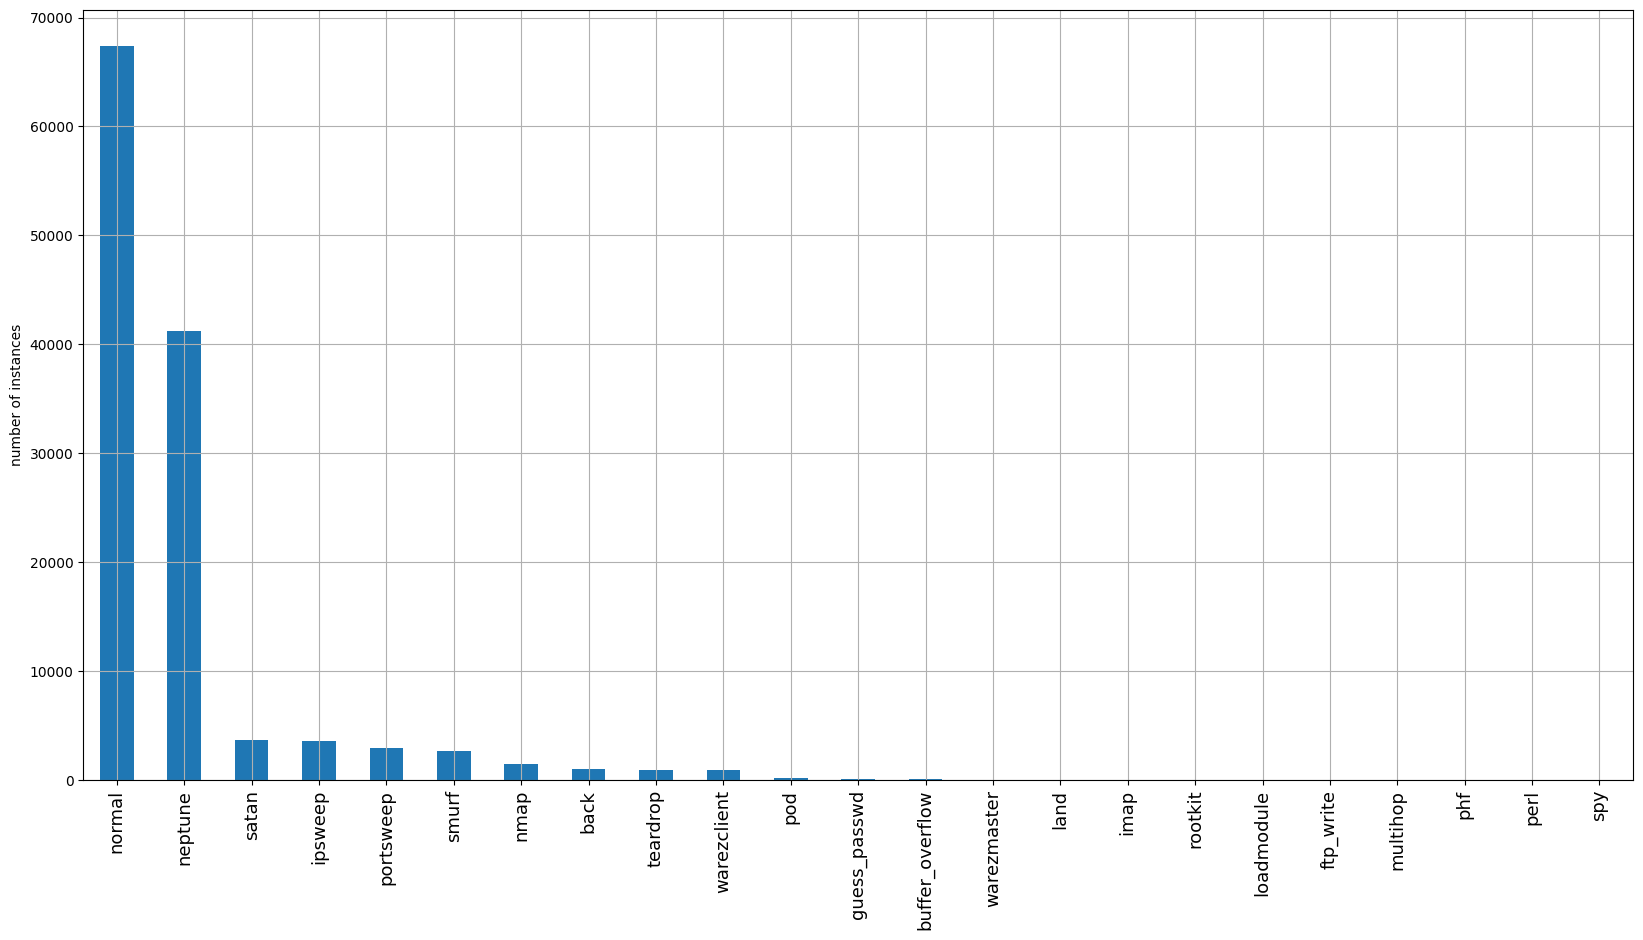

In [63]:
pd.value_counts(df['labels']).plot(kind='bar', figsize=(20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize=13)
plt.grid()
plt.show()

In [64]:
# extracting only the rows which have http service.
df_http = df[(df['service']=='http')]

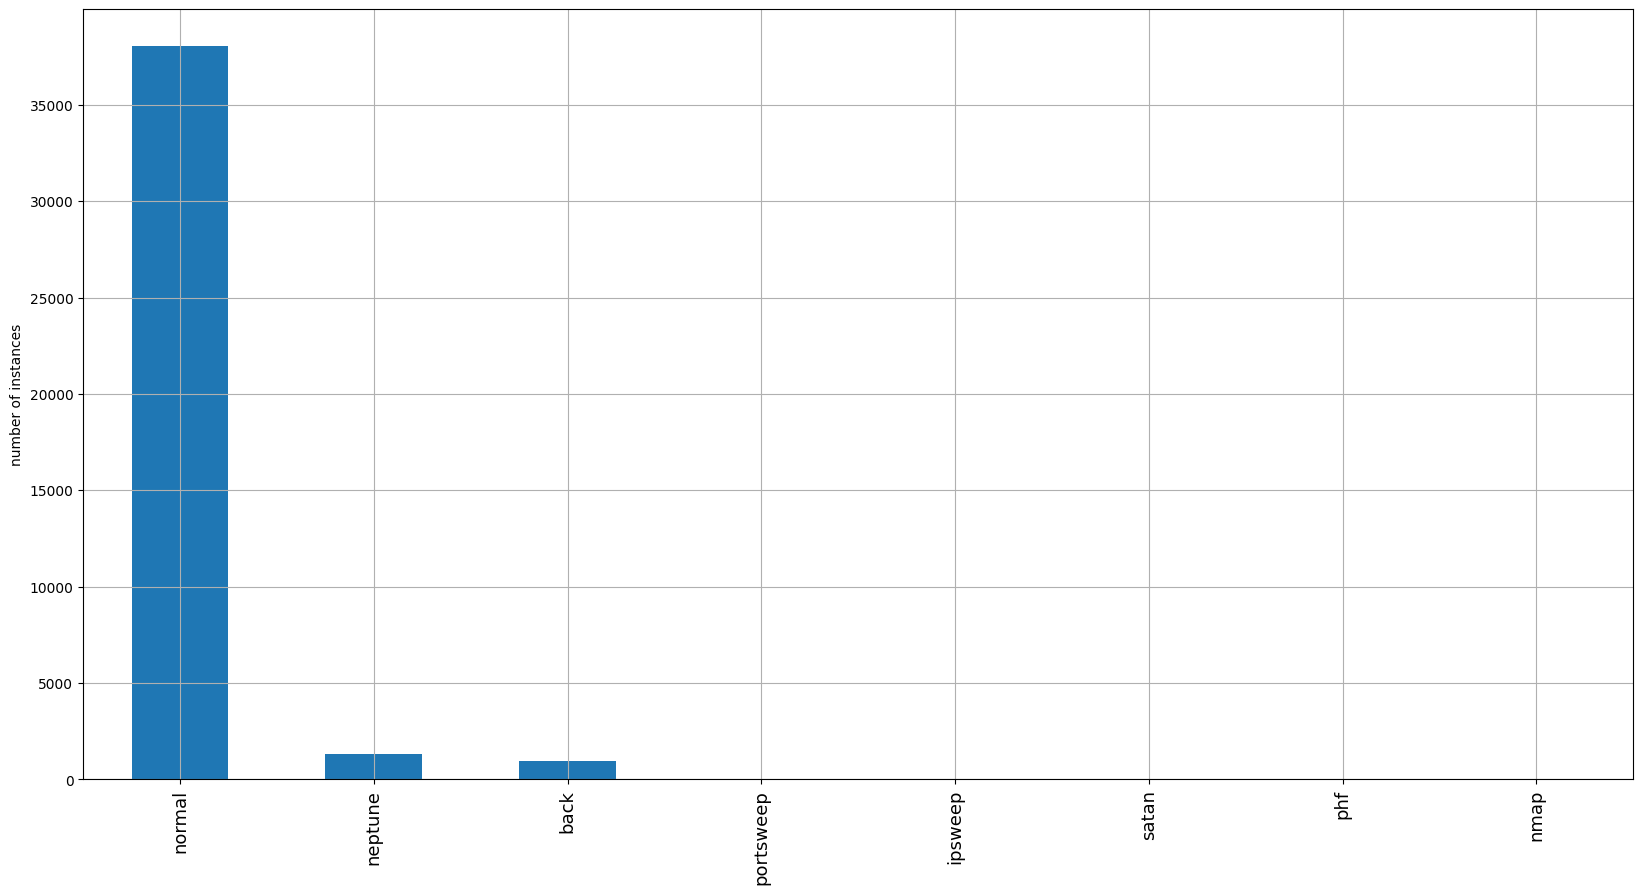

In [65]:
pd.value_counts(df_http['labels']).plot(kind='bar', figsize=(20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize=13)
plt.grid()
plt.show()

In [66]:
normal_instances = df_http[df_http['labels']=='normal'].shape[0]
anomalous_instances = df_http[df_http['labels']!='normal'].shape[0]
print(normal_instances)
print(anomalous_instances)
print('percentage of anomalies = {}'.format(100*anomalous_instances/normal_instances))

38049
2289
percentage of anomalies = 6.015926831191359


In [67]:
df_http_normal = df_http[df_http['labels']=='normal']

In [68]:
df_http_normal.shape

(38049, 42)

In [69]:
# dropping catrgorical columns
df_http_normal.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'labels'], axis=1, inplace=True)
# dropping columns with no std deviation
df_http_normal.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)

<ipython-input-69-c7b3529d7086>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_http_normal.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'labels'], axis=1, inplace=True)
<ipython-input-69-c7b3529d7086>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_http_normal.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)


In [70]:
df_http_normal.describe()

,duration,src_bytes,dst_bytes,hot,num_compromised,root_shell,num_root,num_shells,num_access_files,count,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,38049.000000,38049.000000,3.804900e+04,38049.000000,38049.000000,38049.000000,38049.0,38049.000000,38049.000000,38049.000000,...,38049.000000,38049.000000,38049.000000,38049.000000,38049.000000,38049.000000,38049.000000,38049.000000,38049.000000,38049.000000
mean,0.657021,243.711241,4.571256e+03,0.012274,0.001919,0.001446,0.0,0.000026,0.005151,9.041368,...,125.879314,243.453047,0.996478,0.000993,0.069459,0.030305,0.004876,0.001130,0.069606,0.071019
std,12.395866,318.325400,2.702648e+04,0.167326,0.076533,0.037993,0.0,0.005127,0.071588,12.157668,...,104.716216,42.201227,0.031279,0.011916,0.173045,0.047278,0.044915,0.007129,0.241947,0.240875
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,210.000000,4.710000e+02,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,...,22.000000,255.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,241.000000,1.456000e+03,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,6.000000,...,93.000000,255.000000,1.000000,0.000000,0.010000,0.020000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,303.000000,3.928000e+03,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,13.000000,...,255.000000,255.000000,1.000000,0.000000,0.050000,0.040000,0.000000,0.000000,0.000000,0.000000
max,715.000000,54540.000000,3.746371e+06,9.000000,4.000000,1.000000,0.0,1.000000,1.000000,511.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000


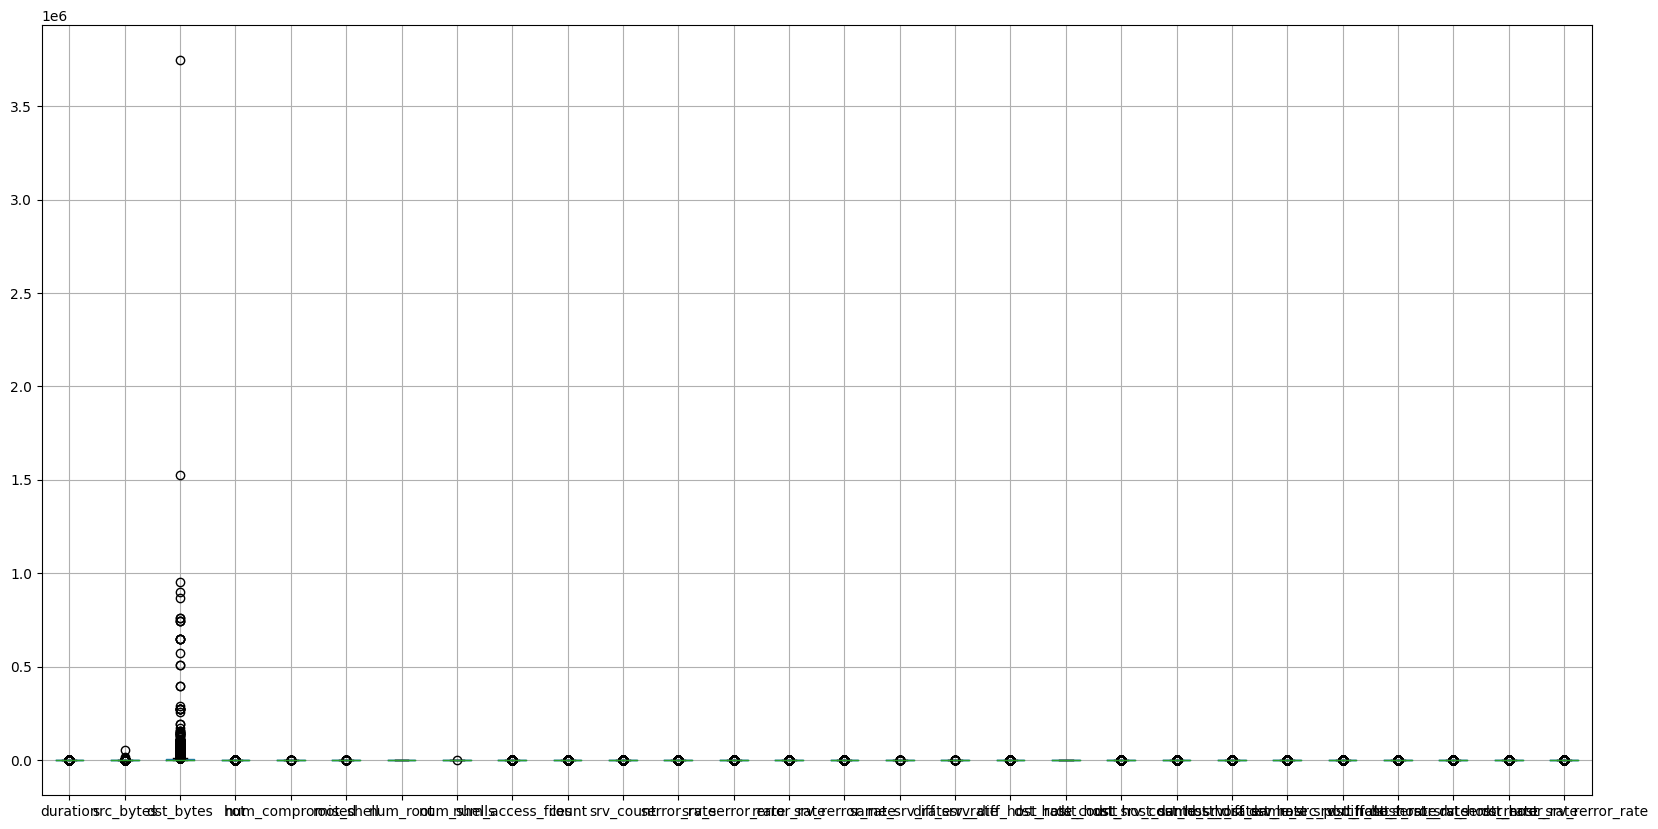

In [71]:
df_http_normal.boxplot(figsize=(20, 10))
plt.show()

In [72]:
# scaling the data using standard scaler
scaler = StandardScaler()
df_http_normal = pd.DataFrame(scaler.fit_transform(df_http_normal), columns=df_http_normal.columns)

In [73]:
# reducing the dimensionality of the data using PCA and covering 80% of the variance in the original data
pca = PCA(n_components=0.80)
pca.fit(df_http_normal)

PCA(n_components=0.8)

In [74]:
pca_cols = ['PCA_'+ str(i) for i in range(pca.n_components_)]
df_pca = pd.DataFrame(pca.transform(df_http_normal), columns=pca_cols)

In [75]:
df_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13
0,0.060903,3.058827,0.106889,0.604668,-0.468816,-0.050319,0.078120,0.137547,-0.388254,0.092866,-0.237951,0.541847,0.223068,-0.395619
1,1.586495,-1.048621,0.591000,1.457358,0.132486,-0.914245,0.713256,-0.064359,0.088131,-0.003905,0.161644,-0.374199,-0.394063,0.285573
2,-0.164215,0.323162,-0.543685,-0.913604,-0.240538,1.020474,-0.147204,-0.158811,0.354402,-0.185615,0.035312,-0.322875,-0.497734,0.926664
3,0.520785,0.637181,-0.178747,-0.075614,-0.025594,-0.028388,-0.447429,0.147918,0.181066,-0.079998,-0.018573,0.051630,0.040788,0.413889
4,0.315955,0.046296,-0.467739,-0.565489,-0.191717,0.384804,-0.311983,0.030976,0.086645,-0.012260,-0.077344,0.318579,0.274779,-0.639200


In [76]:
def get_windows(df, window_size=20, stride=10):
  windows_arr = []
  for i in tqdm.tqdm(range(0, len(df)-window_size+1, stride)):
    windows_arr.append(df.iloc[i:i+window_size, :].to_numpy())
  return np.array(windows_arr)

In [77]:
window_size, stride = 10, 10
windows_arr = get_windows(df_pca, window_size, stride)

100%|██████████| 3804/3804 [00:00<00:00, 20007.29it/s]


In [78]:
# shuffling windows for training purpose
indices = np.arange(windows_arr.shape[0])
np.random.shuffle(indices)
windows_shuffled = windows_arr[indices]

LSTM Autoencoder

In [79]:
K.clear_session()
# encoder model with stacked LSTM
encoder = Sequential([LSTM(80, return_sequences=True, activation='selu',input_shape=(window_size, 14), dropout=0.2), LSTM(50, activation='selu', return_sequences=True), 
                      LSTM(20, activation='selu')], name='encoder')
# decoder model with output dimension same as input dimension
decoder = Sequential([RepeatVector(window_size), LSTM(50, activation='selu', return_sequences=True), LSTM(80, activation='selu',return_sequences=True), 
                      TimeDistributed(Dense(14, activation='linear'))], name='decoder')
# creating sequential autoencoder using encoder, decoder as layers
autoencoder = Sequential([encoder, decoder], name='autoencoder')
autoencoder.compile(optimizer='adam', loss = tf.keras.losses.Huber(100.))
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 20)                62280     
                                                                 
 decoder (Sequential)        (None, 10, 14)            57254     
                                                                 
Total params: 119,534
Trainable params: 119,534
Non-trainable params: 0
_________________________________________________________________


In [80]:
encoder.summary(), decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 80)            30400     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            26200     
                                                                 
 lstm_2 (LSTM)               (None, 20)                5680      
                                                                 
Total params: 62,280
Trainable params: 62,280
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector (RepeatVector  (None, 10, 20)           0         
 )                                                               
                                      

(None, None)

In [81]:
check_point = tf.keras.callbacks.ModelCheckpoint('autoencoder.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
train_hist = autoencoder.fit(windows_shuffled, windows_shuffled[:, :, ::-1], batch_size=64, validation_split=0.2, epochs=100, callbacks=[check_point])

Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 0.7985
Epoch 1: val_loss improved from inf to 0.60525, saving model to autoencoder.h5
48/48 [==============================] - 11s 91ms/step - loss: 0.7985 - val_loss: 0.6052
Epoch 2/100
48/48 [==============================] - ETA: 0s - loss: 0.7734
Epoch 2: val_loss improved from 0.60525 to 0.58874, saving model to autoencoder.h5
48/48 [==============================] - 3s 53ms/step - loss: 0.7734 - val_loss: 0.5887
Epoch 3/100
48/48 [==============================] - ETA: 0s - loss: 0.7551
Epoch 3: val_loss improved from 0.58874 to 0.57438, saving model to autoencoder.h5
48/48 [==============================] - 2s 52ms/step - loss: 0.7551 - val_loss: 0.5744
Epoch 4/100
48/48 [==============================] - ETA: 0s - loss: 0.7429
Epoch 4: val_loss improved from 0.57438 to 0.55942, saving model to autoencoder.h5
48/48 [==============================] - 2s 51ms/step - loss: 0.7429 - val_loss: 0.5594
Epoch 5/100
48/

In [82]:
# restoring the best model
autoencoder_loaded = tf.keras.models.load_model('autoencoder.h5') 

Testing

In [100]:
# loading the test dataframe
test_df = pd.read_csv('kdd_test1.csv')
test_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,5,tcp,smtp,SF,2429,475,0,0,0,0,...,57,0.11,0.02,0.01,0.04,0.0,0.0,0.87,0.0,normal
1,0,udp,domain_u,SF,45,134,0,0,0,0,...,155,0.80,0.02,0.01,0.00,0.0,0.0,0.00,0.0,normal
2,0,udp,domain_u,SF,45,80,0,0,0,0,...,255,1.00,0.00,0.01,0.00,0.0,0.0,0.00,0.0,normal
3,1979,udp,other,SF,145,105,0,0,0,0,...,2,0.01,0.84,1.00,0.00,0.0,0.0,0.00,0.0,normal
4,14462,tcp,other,RSTR,1,0,0,0,0,0,...,2,0.01,0.68,1.00,0.00,0.0,0.0,1.00,1.0,portsweep


In [114]:
# slicing only the rows belonging to http service
test_df_http = test_df[test_df['service']=='http']

In [115]:
# binary indicator to represent anomalies
status = pd.Series([0 if i=='normal' else 1 for i in test_df_http['labels']])
test_labels = [1 if np.sum(status[i:i+window_size])>0 else 0 for i in range(0, len(status)-window_size+1, stride)]

In [117]:
# dropping catrgorical columns
test_df_http.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'labels'], axis=1, inplace=True)
# dropping columns with no std deviation
test_df_http.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)

<ipython-input-117-e48dd4a85e10>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_http.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'labels'], axis=1, inplace=True)
<ipython-input-117-e48dd4a85e10>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_http.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)


In [118]:
test_df_http = pd.DataFrame(scaler.transform(test_df_http), columns=test_df_http.columns)

In [119]:
test_df_http_pca = pd.DataFrame(pca.transform(test_df_http), columns=pca_cols)
test_df_http_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13
0,-0.345419,0.664954,-0.988451,-0.947686,-0.292698,1.732467,0.193150,0.039521,0.910471,-0.165898,0.348132,-0.574987,0.728313,-0.803837
1,-10.479049,45.178478,36.100938,13.225636,-9.492797,36.257049,45.666569,-3.405948,-67.422601,11.620935,-30.432607,37.107212,-42.092498,15.744230
2,0.953624,2.148239,0.499395,0.664450,-0.283099,-1.387604,-1.131352,-0.107883,-0.189022,0.071750,-0.267788,0.738159,0.482340,-0.350207
3,0.460013,-0.130629,-0.398180,-0.001432,-0.122560,0.569878,0.462076,-0.078124,0.427678,-0.101813,0.222591,-0.327818,0.282132,0.115686
4,-1.245821,1.237710,-1.040100,-1.402292,-0.551782,3.028035,1.018591,0.015160,1.351732,-0.248137,0.559789,-1.271827,0.577348,-1.251273


In [120]:
test_windows = get_windows(test_df_http_pca, window_size=10, stride=10)

100%|██████████| 730/730 [00:00<00:00, 16568.41it/s]


In [121]:
test_windows_pred = autoencoder_loaded.predict(test_windows)

23/23 [==============================] - 0s 11ms/step


In [122]:
# calculating reconstruction error for each sample
# implemented in tensorflow for faster execution when gpu is available

def get_recon_erros(true_windows, pred_windows):
  recon_errors = []

  def cond(y_true, y_pred, i, iters):
    return tf.less(i, iters)

  def body(y_true, y_pred, i, iters):
    tensor_for_error = tf.math.subtract(tf.slice(y_true, [i, 0, 0], [1, -1, -1]), tf.slice(y_pred, [i, 0, 0], [1, -1, -1]))
    tensor_for_error = tf.reshape(tensor_for_error, [window_size, pca.n_components_])
    recon_error = tf.math.reduce_mean(tf.norm(tensor_for_error, ord='euclidean', axis=1))
    # this is the list initialized above
    recon_errors.append(recon_error.numpy())
    return [y_true, y_pred, tf.add(i, 1), iters]

  iters = tf.constant(len(true_windows))

  result = tf.while_loop(cond, body, [tf.constant(true_windows.astype(np.float32)), tf.constant(pred_windows.astype(np.float32)), 0, iters])
  return recon_errors

In [123]:
recon_errors = get_recon_erros(test_windows, test_windows_pred)
recon_errors = np.array(recon_errors).reshape(-1, 1)

In [124]:
# scaling the reconstruction errors set to [0, 1] scale
mm_scaler = MinMaxScaler()
anomaly_scores = mm_scaler.fit_transform(recon_errors).flatten()

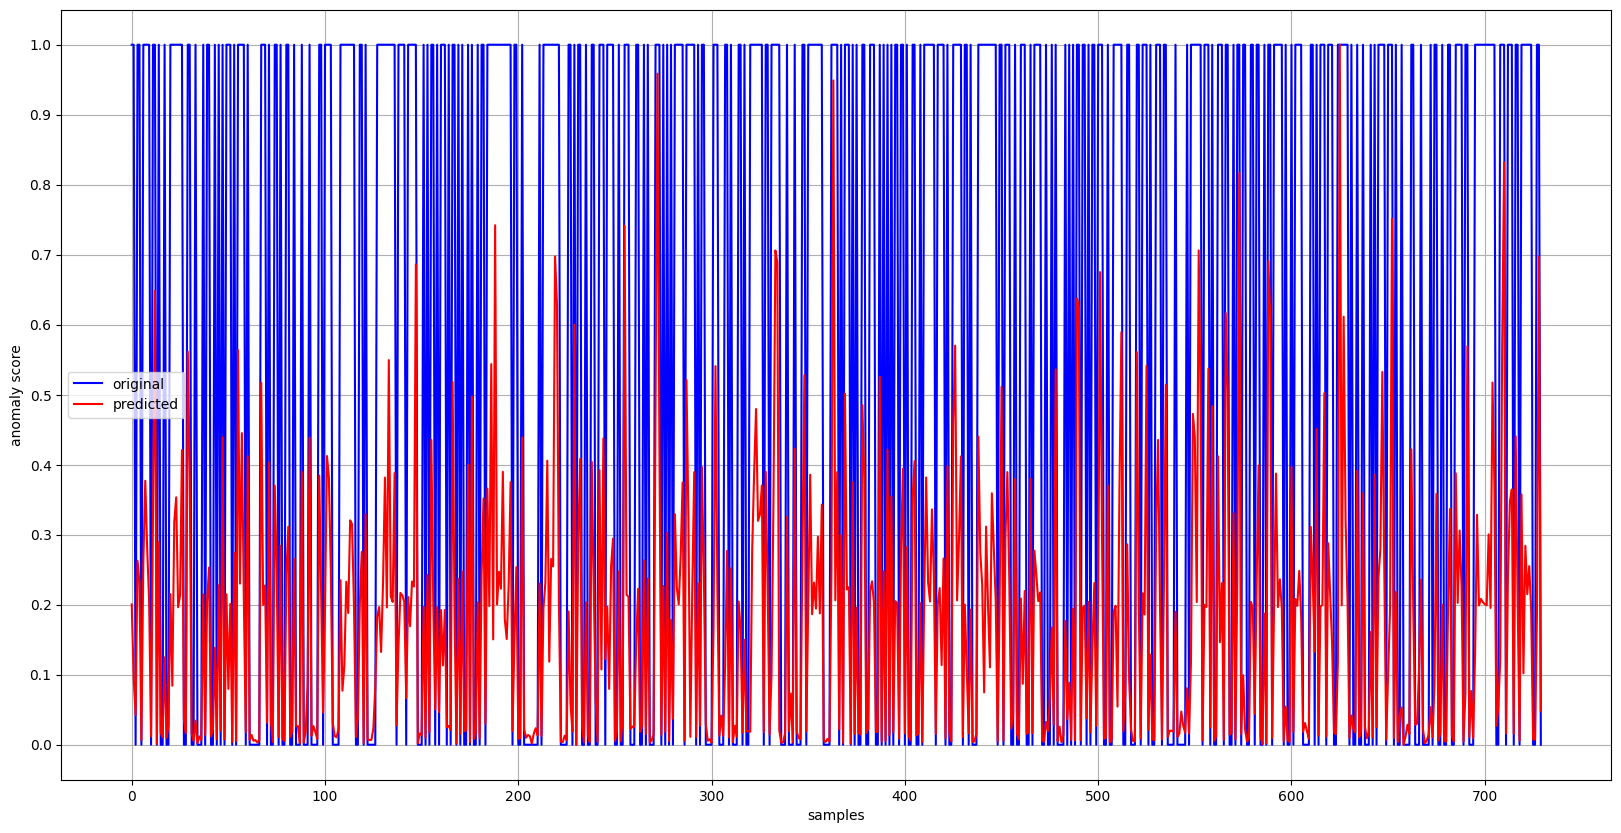

In [125]:
plt.figure(figsize=(20, 10))
plt.plot(test_labels, c='blue', label='original')
plt.plot(anomaly_scores, c='red', label='predicted')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.grid()
plt.legend()
plt.show()

Measuring the effectiveness of classifier

In [126]:
fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)

In [127]:
auc = roc_auc_score(test_labels, anomaly_scores)
print('Area under ROC curve: {}'.format(auc))

Area under ROC curve: 0.9948067335508094


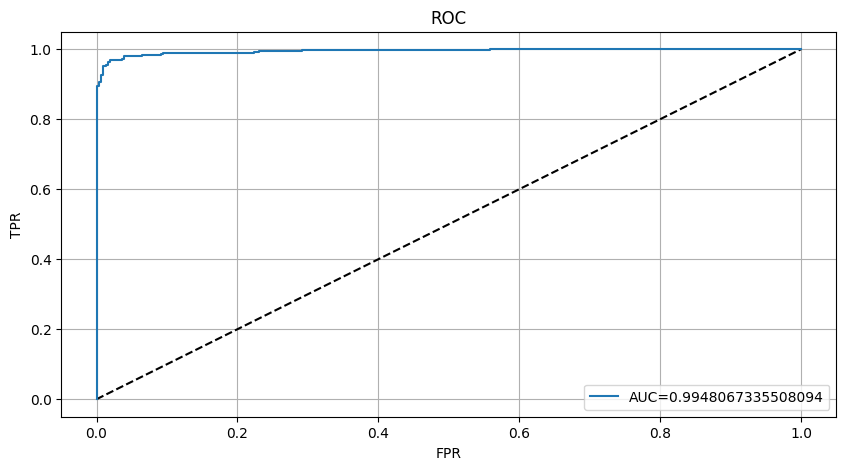

In [128]:
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], color = 'black', linestyle='--')
plt.plot(fpr, tpr, label='AUC={}'.format(auc))
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC')
plt.show()


Identifying anomalies in test set

In [129]:
anomaly_combinations = [(anomaly_scores>i).astype(np.int32) for i in thresholds]
f1_scores = [f1_score(test_labels, i) for i in anomaly_combinations]

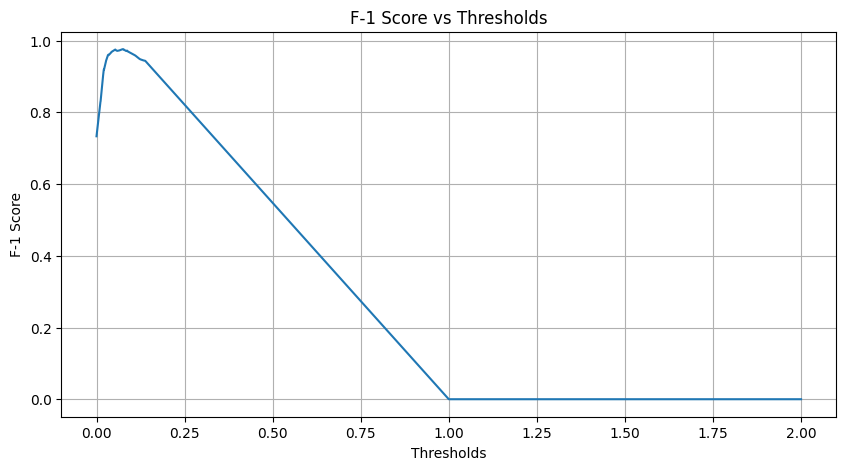

In [130]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores)
plt.grid()
plt.xlabel('Thresholds')
plt.ylabel('F-1 Score')
plt.title('F-1 Score vs Thresholds')
plt.show()

In [131]:
max_f1_score = np.max(f1_scores)
best_threshold = thresholds[f1_scores.index(max_f1_score)]
print('best threshold = {}'.format(best_threshold))

best threshold = 0.0737524926662445


In [132]:
anomaly_indicator = (anomaly_scores>best_threshold).astype(np.int32)

In [133]:
confusion_matrix(test_labels, anomaly_indicator)

array([[302,   6],
       [ 14, 408]])

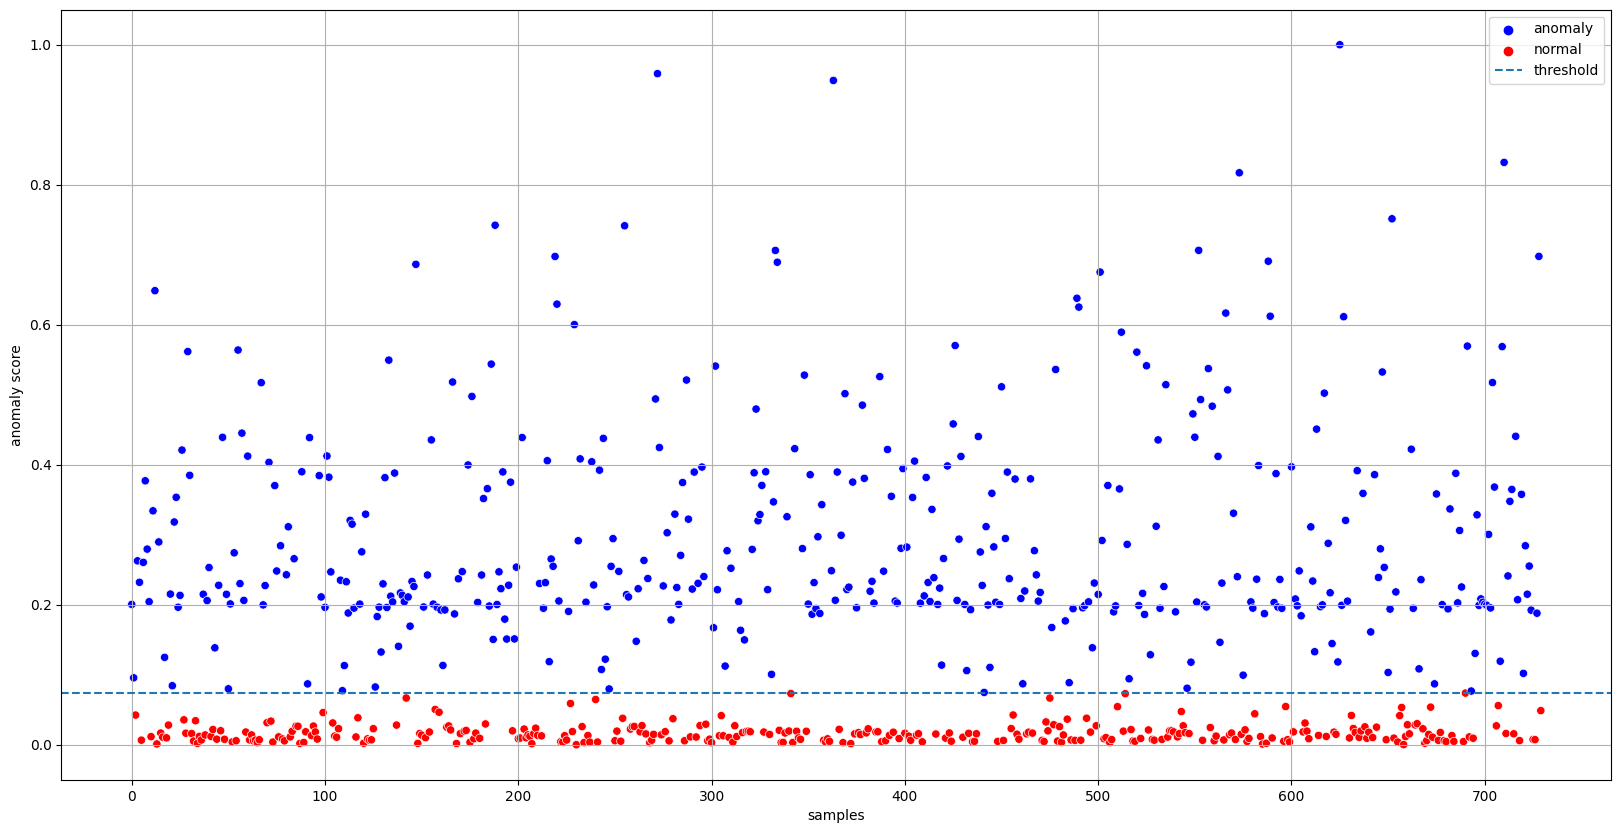

In [134]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(anomaly_scores)), y= anomaly_scores, hue=['normal' if i==0 else 'anomaly' for i in anomaly_indicator],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = best_threshold, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

In [135]:
precision = precision_score(test_labels, anomaly_indicator)
recall = recall_score(test_labels, anomaly_indicator)
f1_sc = f1_score(test_labels, anomaly_indicator)
accuracy_sc = accuracy_score(test_labels, anomaly_indicator)

In [136]:
print('Model has the following classification metrics:\n precision = {}\n recall = {}\n f1_score = {}\n accuracy_score = {}'
      .format(precision, recall, f1_sc, accuracy_sc))

Model has the following classification metrics:
 precision = 0.9855072463768116
 recall = 0.966824644549763
 f1_score = 0.9760765550239234
 accuracy_score = 0.9726027397260274
